In [1]:
import numpy as np 
import itertools
import functools
import seaborn as sns 
import matplotlib.pyplot as plt 
from LeastSquareClassification import LeastSquareClassification

In [2]:
def get_combinations(x, degree) : 
    return itertools.combinations_with_replacement(x, degree)

def compute_new_feature(items) : 
    return functools.reduce(lambda x, y : x*y, items)
    
def polynomial_transform(x, degree, logging = False) : 
    # convert to feature matrix 
    if x.ndim == 1 : 
        x = x[:,None]

    x_t = x.transpose()
    feature = [np.ones(len(x))] # populates 1s as first feature for each example 

    if logging : 
        print('Input : ', x)

    for degree in range(1, degree + 1) : 
        for items in get_combinations(x_t, degree) :  # generate combinations
            feature.append(compute_new_feature(items)) # combine feature into a new feature 
            if logging : 
                print(items, " : ", compute_new_feature(items))
    
    if logging : 
        print(np.asarray(feature).transpose())
    
    return np.asarray(feature).transpose()

In [3]:
class LabelTransformer(object) : 
    def __init__(self, n_classes: int = None) : 
        self.n_classes = n_classes

    @property
    def n_classes(self) : 
        return self.__n_classes

    @n_classes.setter 
    def n_classes(self, K) : 
        self.__n_classes = K 
        self.__encoder = None if K is None else np.eye(K)

    @property 
    def encoder(self) : 
        return self.__encoder

    def encode(self, class_indices:np.ndarray): 
        if self.n_classes is None : 
            self.n_classes = np.max(class_indices) + 1
        return self.encoder[class_indices]

    def decode(self, onehot : np.ndarray) : 
        return np.argmax(onehot, axis = 1)


In [4]:
binary_labels = LabelTransformer(2).encode(np.array([1, 0, 1, 0]))
binary_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [5]:
multiclass_labels = LabelTransformer(3).encode(np.array([1, 0, 1, 2]))
multiclass_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [6]:
def create_toy_data(add_outlier = False, add_class = False) : 
    x0 = np.random.normal(size = 50).reshape(-1, 2) - 1 
    x1 = np.random.normal(size = 50).reshape(-1, 2) + 1. 
    if add_outlier : 
        x_1 = np.random.normal(size = 10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)

    if add_class : 
        x2 = np.random.normal(size = 50).reshape(-1, 2) + 2. 
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

In [7]:
from sklearn.model_selection import train_test_split 

def preprocess(add_class = False, add_outlier = False, degree = 1) : 
    X, y = create_toy_data(add_outlier, add_class)
    x_poly = polynomial_transform(X, degree= degree)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y)
    y_train_trans = LabelTransformer().encode(y_train)
    y_test_trans = LabelTransformer().encode(y_test)
    return x_train, x_test, y_train, y_test, y_train_trans, y_test_trans 

In [8]:
sns.set_context('notebook', font_scale= 1.5, rc = {'lines.linewidth' : 2.5})

def visualize_model(x_train, labels, lsc_obj, degree = 1) : 
    f = plt.figure(figsize=(8, 8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.max(x_train[:,2])

    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    x_test = np.array([x1_test, x2_test]).reshape(2, -1).T
    x_test_poly = polynomial_transform(x_test, degree= degree)
    y_test = lsc_obj.predict(x_test_poly)

    sns.scatterplot(data = x_train, x = x_train[:, 1], y = x_train[:,2], hue = labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100, 100), alpha = 0.5, levels = np.linspace(0, 1, 3))

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.gca().set_aspect('equal', adjustable = 'box')
    plt.show()

In [9]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess()

C:\Users\Computer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == "":


In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(37, 3)
(37,)
(13, 3)
(13,)


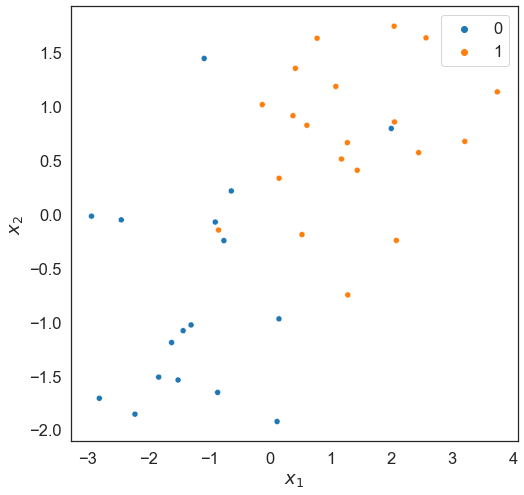

In [11]:
sns.set_style('white')
f = plt.figure(figsize= (8,8))
sns.set_context('notebook', font_scale=1.5, rc = {'lines.linewidth' : 2.5})

sns.scatterplot(data = x_train, x = x_train[:, -2], y = x_train[:,-1], hue = y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [12]:
lsc = LeastSquareClassification()

weight vector :  [[ 0.49252185  0.50747815]
 [-0.15578055  0.15578055]
 [-0.15428567  0.15428567]]


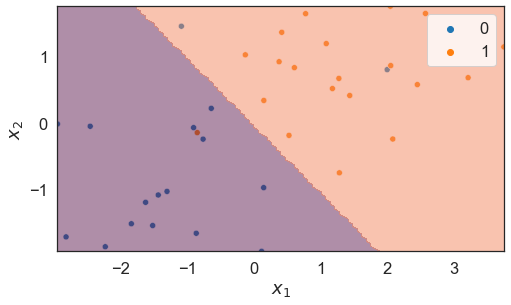

In [13]:
lsc.fitMulti(x_train, y_train_trans, reg_rate = 0)
print('weight vector : ', lsc.w)
visualize_model(x_train, y_train, lsc)

In [14]:
def plot_learning_curve(err_all) : 
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'r-')
    plt.xlabel('Iter #')
    plt.ylabel('$\mathbf{J(w)}$')

100%|██████████| 100/100 [00:00<00:00, 606.09it/s]


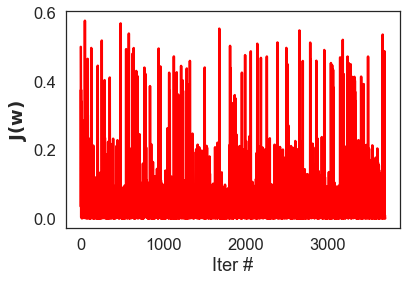

In [15]:
lsc.sgd(x_train, y_train_trans, num_epochs = 100, reg_rate= 0)
plot_learning_curve(lsc.err_all)

100%|██████████| 100/100 [00:00<00:00, 25070.56it/s]


[[ 0.48066623  0.49499429]
 [-0.15661487  0.16122678]
 [-0.15076681  0.14525392]]


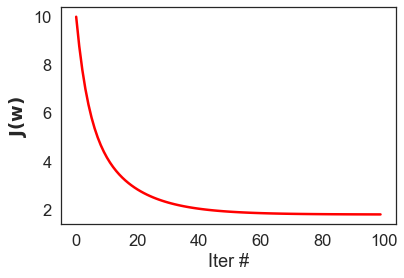

In [16]:
lsc = LeastSquareClassification()
lsc.gradient_descent(x_train, y_train_trans, num_epochs = 100, lr = 1e-3, reg_rate= 0)
plot_learning_curve(lsc.err_all)
print(lsc.w)

# Evaluation : 

In [17]:
y_test_hat = lsc.predict(x_test)

In [18]:
tp = np.where((y_test == 1) & (y_test_hat == 1), 1, 0).sum()
tn = np.where((y_test == 0) & (y_test_hat == 0), 1, 0).sum()
fp = np.where((y_test == 0) & (y_test_hat == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_test_hat == 0), 1, 0).sum()

In [19]:
def precision(tp, fp) : 
    if (tp+fp) == 0 : return np.NaN
    return tp/(tp+fp)

def recall(tp, fn) : 
    if (tp+fn) == 0 : return np.NaN
    return tp/(tp+fn)

def accuracy(tp, fp, tn, fn) : 
    return (tp+tn)/(tp + fp + tn + fn)

def f1_score(pr, r) : 
    return 2 * ((pr * r)/(pr + r))

In [20]:
print('precision',precision(tp, fp))
print('recall',recall(tp, fn))
print('accuracy',accuracy(tp, fp, tn, fn))
print('f1 score',f1_score(precision(tp, fp), recall(tp, fn)))

precision 1.0
recall 0.8
accuracy 0.9230769230769231
f1 score 0.888888888888889


## With outlier

In [21]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_outlier= True)

C:\Users\Computer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [22]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(41, 3)
(41,)
(14, 3)
(14,)


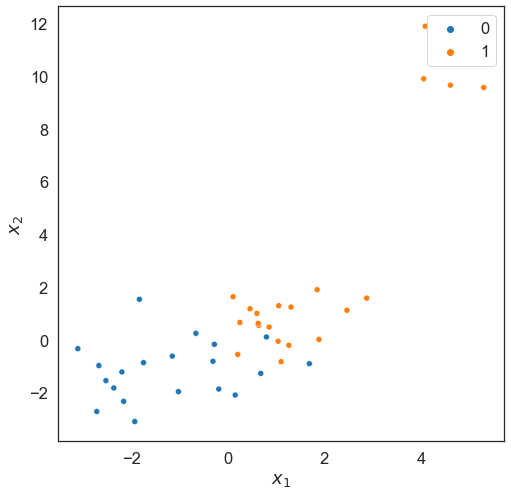

In [23]:
sns.set_style('white')
f = plt.figure(figsize= (8,8))
sns.set_context('notebook', font_scale=1.5, rc = {'lines.linewidth' : 2.5})

sns.scatterplot(data = x_train, x = x_train[:, -2], y = x_train[:,-1], hue = y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

its sensitive to the outliers

weight vector :  [[ 0.541932    0.458068  ]
 [-0.18496216  0.18496216]
 [ 0.00780914 -0.00780914]]


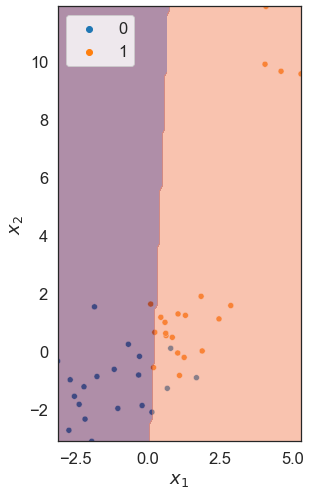

In [24]:
lsc = LeastSquareClassification()
lsc.fitMulti(x_train, y_train_trans, reg_rate = 0)
print('weight vector : ', lsc.w)
visualize_model(x_train, y_train, lsc)

## Multiclass

In [25]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_class= True)

C:\Users\Computer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [26]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(56, 3)
(56,)
(19, 3)
(19,)


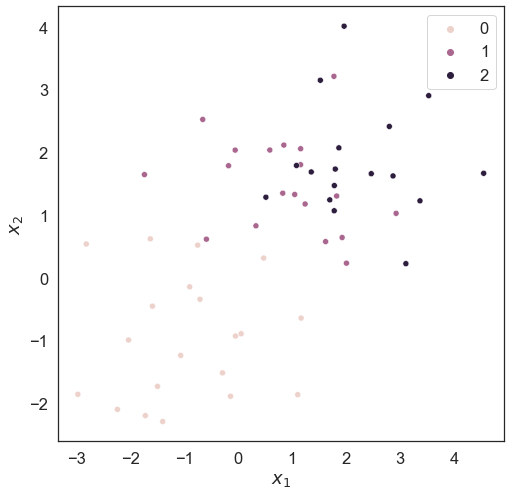

In [27]:
sns.set_style('white')
f = plt.figure(figsize= (8,8))
sns.set_context('notebook', font_scale=1.5, rc = {'lines.linewidth' : 2.5})

sns.scatterplot(data = x_train, x = x_train[:, -2], y = x_train[:,-1], hue = y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

weight vector :  [[ 0.55938077  0.26577361  0.17484562]
 [-0.09306475 -0.04950394  0.1425687 ]
 [-0.19925243  0.14466085  0.05459159]]


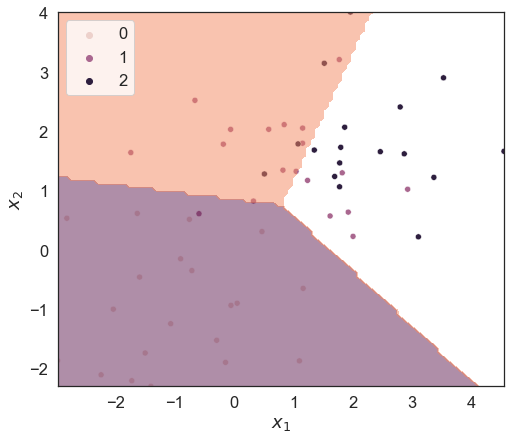

In [28]:
lsc_multi = LeastSquareClassification()
lsc_multi.fitMulti(x_train, y_train_trans, reg_rate = 0)
print('weight vector : ', lsc_multi.w)
visualize_model(x_train, y_train, lsc_multi)

In [29]:
lsc_multi.w

array([[ 0.55938077,  0.26577361,  0.17484562],
       [-0.09306475, -0.04950394,  0.1425687 ],
       [-0.19925243,  0.14466085,  0.05459159]])

In [30]:
from sklearn.metrics import classification_report 

y_test_pred = lsc_multi.predict(x_test)
print(classification_report(y_test, y_test_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.50      0.33      0.40         6
           2       0.56      0.62      0.59         8

    accuracy                           0.63        19
   macro avg       0.63      0.65      0.63        19
weighted avg       0.61      0.63      0.61        19



## non linear decision boundary 

In [31]:
from sklearn.datasets import make_circles
x, y = make_circles()

In [32]:
x_poly = polynomial_transform(x, degree= 2)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

In [33]:
print(x.shape)
print(x_poly.shape)

(100, 2)
(100, 6)


In [34]:
x[:5], x_poly[:5]

(array([[ 0.74382119, -0.29449964],
        [ 0.50993919, -0.61641059],
        [-0.34062343, -0.72386164],
        [ 1.        ,  0.        ],
        [ 0.14990505,  0.7858298 ]]),
 array([[ 1.        ,  0.74382119, -0.29449964,  0.55326996, -0.21905507,
          0.08673004],
        [ 1.        ,  0.50993919, -0.61641059,  0.26003798, -0.31433192,
          0.37996202],
        [ 1.        , -0.34062343, -0.72386164,  0.11602432,  0.24656424,
          0.52397568],
        [ 1.        ,  1.        ,  0.        ,  1.        ,  0.        ,
          0.        ],
        [ 1.        ,  0.14990505,  0.7858298 ,  0.02247152,  0.11779986,
          0.61752848]]))

In [35]:
y_train_trans = LabelTransformer().encode(y_train)
y_test_trans = LabelTransformer().encode(y_test)

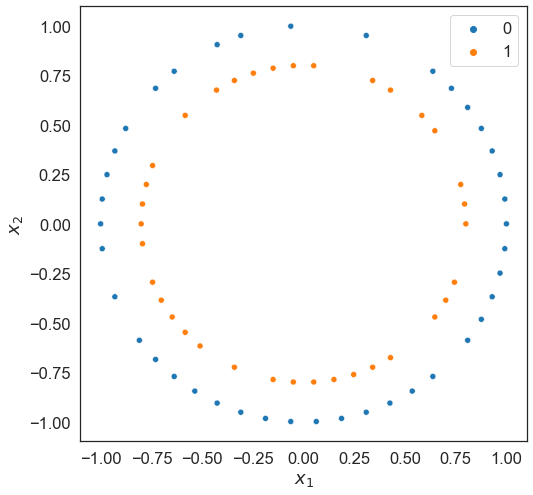

In [36]:
sns.set_style('white')
f = plt.figure(figsize= (8,8))
sns.set_context('notebook', font_scale=1.5, rc = {'lines.linewidth' : 2.5})

sns.scatterplot(data = x_train, x = x_train[:, 1], y = x_train[:,2], hue = y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

weight vector :  [[-1.77777778e+00  2.77777778e+00]
 [-1.12064599e-16  1.12064599e-16]
 [-2.67485709e-16  2.67485709e-16]
 [ 2.77777778e+00 -2.77777778e+00]
 [-2.03600180e-16  2.58741895e-16]
 [ 2.77777778e+00 -2.77777778e+00]]


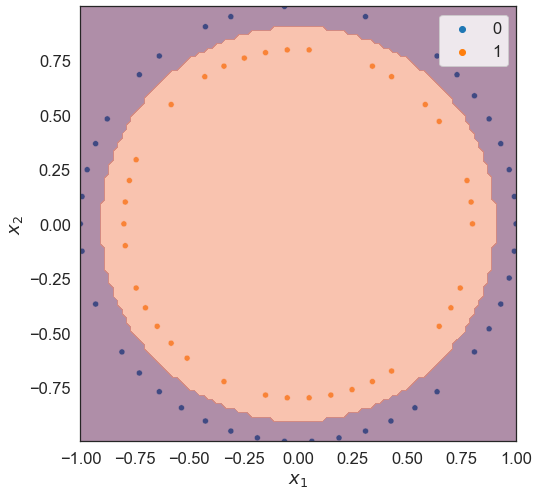

In [37]:
lsc_poly = LeastSquareClassification()
lsc_poly.fitMulti(x_train, y_train_trans, reg_rate = 0)
print('weight vector : ', lsc_poly.w)
visualize_model(x_train, y_train, lsc_poly, degree= 2)

In [38]:
from sklearn.metrics import classification_report 

y_test_pred = lsc_poly.predict(x_test)
print(classification_report(y_test, y_test_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        15

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

